In [177]:
import sys
sys.path.append('/Users/sdbykov/work/self-supervised-halos/')

In [178]:
import requests
import numpy as np
import h5py
from tqdm import tqdm
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from utils.data.tng_query import get, HaloInfo, subhalos_df, subhalos_mass_history
from utils.utils import data_path, res_path, set_mpl
set_mpl()

data_path = data_path+'tng/'

matplotlib settings set


In [179]:
histories_df = pd.DataFrame(subhalos_mass_history).T
histories_df.index.name = 'subhalo_id'

#make mass and snap as np.arrayy for each halo
histories_df['mass'] = histories_df['mass'].apply(np.array)
histories_df['snap'] = histories_df['snap'].apply(np.array)
histories_df['log_subhalomass'] = histories_df.apply(lambda x: np.log10(x['mass'][0]), axis=1)

In [180]:
histories_df.loc[59551]['log_subhalomass']

14.537899

# Exploratory analysis

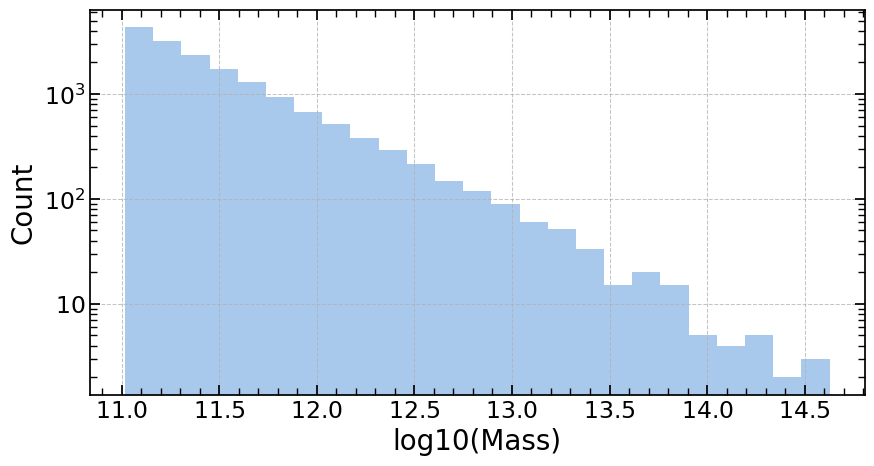

In [181]:
x = subhalos_df['logSubhaloMass']

plt.figure(figsize=(10, 5))
plt.hist(x, bins=25)
plt.yscale('log')
plt.xlabel('log10(Mass)')
plt.ylabel('Count')
plt.show()

In [182]:
plot_halos = True
if plot_halos:

    from utils.data.tng_query import HaloInfo
    from matplotlib.backends.backend_pdf import PdfPages

    n_to_plot = 20

    #set seed for reproducibility
    np.random.seed(111)
    #test_ids = subhalos_df.sample(n_to_plot).index
    #instead of random sample, split subhalos into 10 groups by log mass and take two from each group randomly
    subhalos_df['mass_group'] = pd.cut(subhalos_df['logSubhaloMass'], 10, labels=False)
    test_ids = []
    for i in range(10):
        group = subhalos_df[subhalos_df['mass_group']==i]
        test_ids.extend(group.sample(2).index)
        

    halo_dict = {}

    with PdfPages(res_path+'plots/halo_examples.pdf') as pdf:

        for i, id in enumerate(test_ids[::-1]):
            halo = HaloInfo(id)
            dens = halo.make_3d_density()
            fig, _ = halo.plot_all(dens, compact=True)

            pdf.savefig(fig)

            plt.close(fig)

            halo_dict[id] = halo


Using precomputed histogram: 144093
Using precomputed histogram: 24681
Using precomputed histogram: 200667
Using precomputed histogram: 122842
Using precomputed histogram: 268813
Using precomputed histogram: 274535
Using precomputed histogram: 405560
Using precomputed histogram: 377311
Using precomputed histogram: 515604
Using precomputed histogram: 489757
Using precomputed histogram: 580180
Using precomputed histogram: 540773
Using precomputed histogram: 634793
Using precomputed histogram: 653553
Using precomputed histogram: 758466
Using precomputed histogram: 770598
Using precomputed histogram: 853987
Using precomputed histogram: 794521
Using precomputed histogram: 881273
Using precomputed histogram: 910394


## Explore mass histories

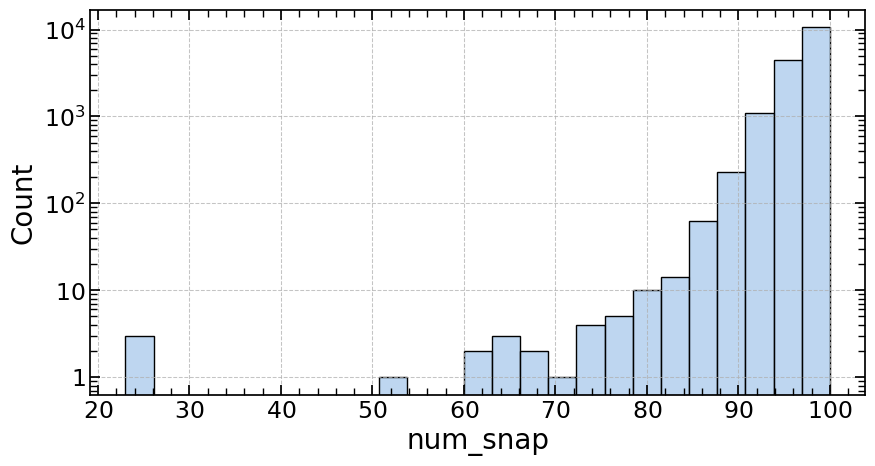

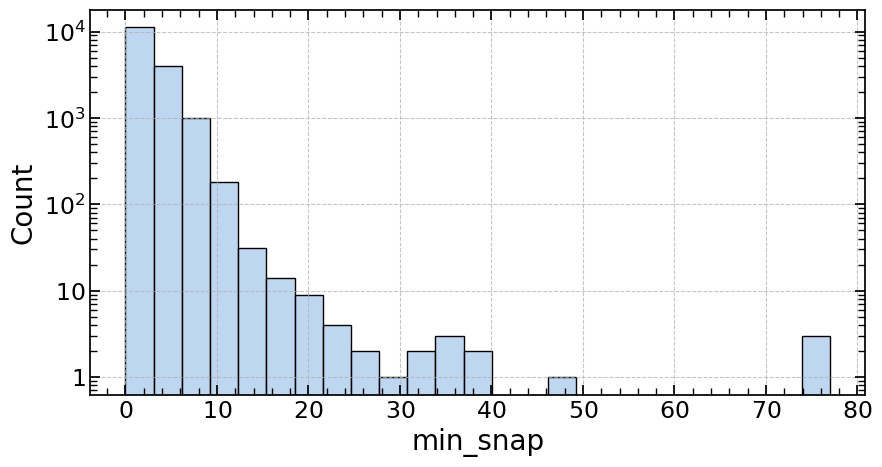

In [183]:
#make arrays of of each column
for col in histories_df.columns:
    histories_df[col] = histories_df[col].apply(lambda x: np.array(x))

histories_df['num_snap'] =  histories_df['snap'].apply(lambda x: len(x))
histories_df['min_snap'] =  histories_df['snap'].apply(lambda x: np.min(x))

plt.figure(figsize=(10, 5))
sns.histplot(histories_df['num_snap'], bins=25)
plt.yscale('log')

plt.figure(figsize=(10, 5))
sns.histplot(histories_df['min_snap'], bins=25)
plt.yscale('log')



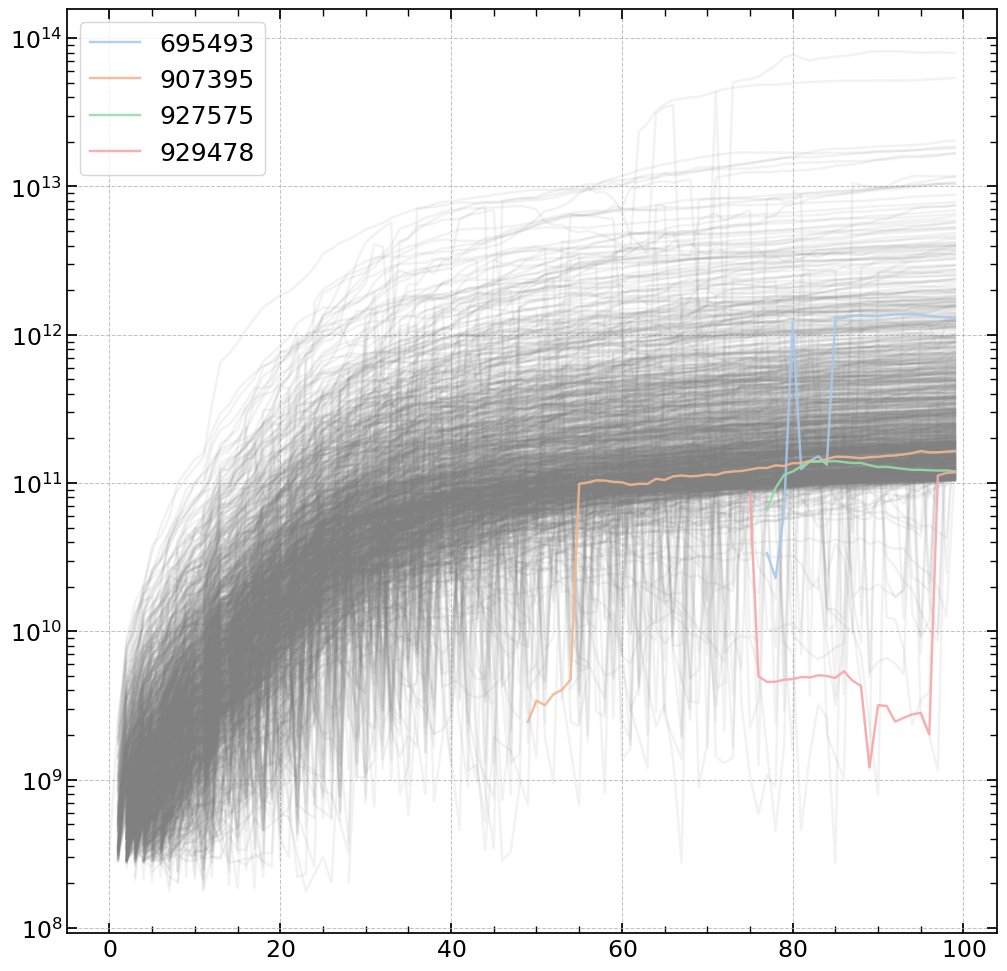

In [184]:
fig,  ax =  plt.subplots( figsize = (12,12))

for row in histories_df.sample(1000).index:
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.1, color = 'gray')


for row in histories_df.query('min_snap>70 | num_snap<60').index:
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.9, label=row)



ax.set_yscale('log')
ax.legend()



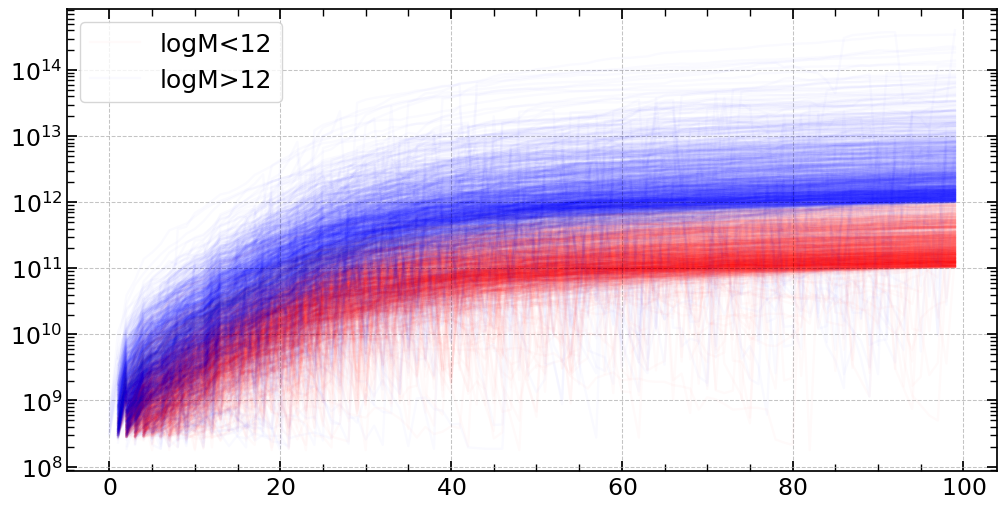

In [185]:
fig,  ax =  plt.subplots( figsize = (12,6))

for i, row in enumerate(histories_df.query('log_subhalomass<12').sample(1000).index):
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.02, color = 'red', label = 'logM<12' if i==0 else None)


for i, row in enumerate(histories_df.query('log_subhalomass>12').sample(1000).index):
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.02, color = 'blue', label = 'logM>12' if i==0 else None)


ax.set_yscale('log')
ax.legend()




In [186]:
histories_df['mass_diff'] = histories_df['mass'].apply(lambda x: np.diff(x))
histories_df['mass_diff_neg_count'] = histories_df['mass_diff'].apply(lambda x: np.sum(x>0)) #>0 because snap is reversed


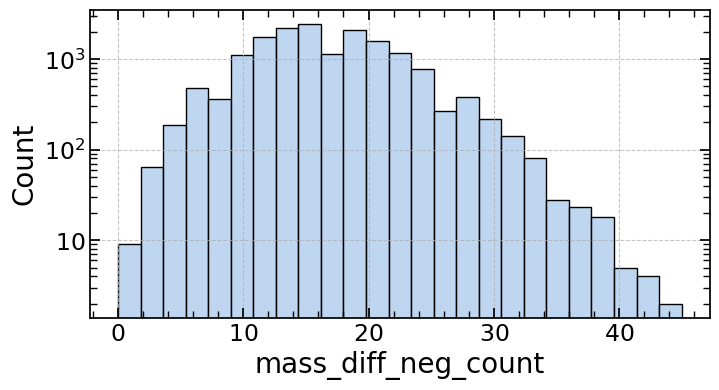

In [187]:
fig,  ax =  plt.subplots( figsize = (8,4))
sns.histplot(histories_df['mass_diff_neg_count'], bins=25, ax=ax)
ax.set_yscale('log')

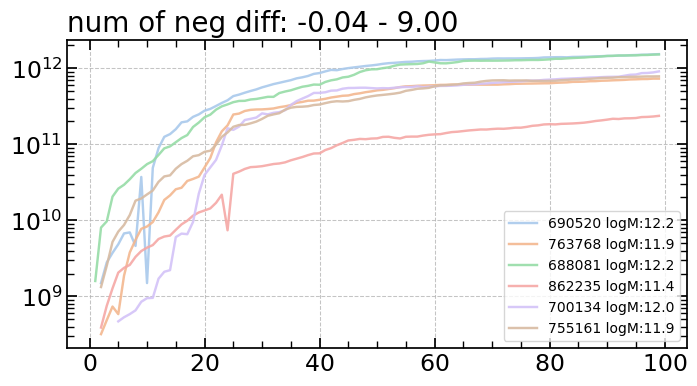

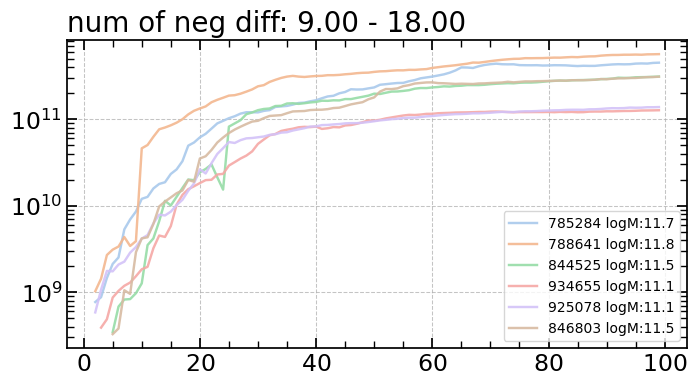

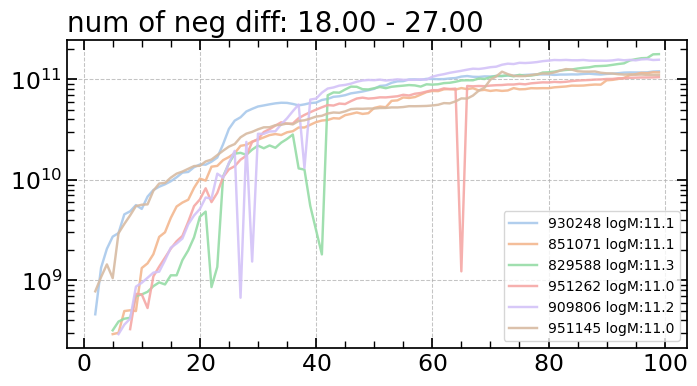

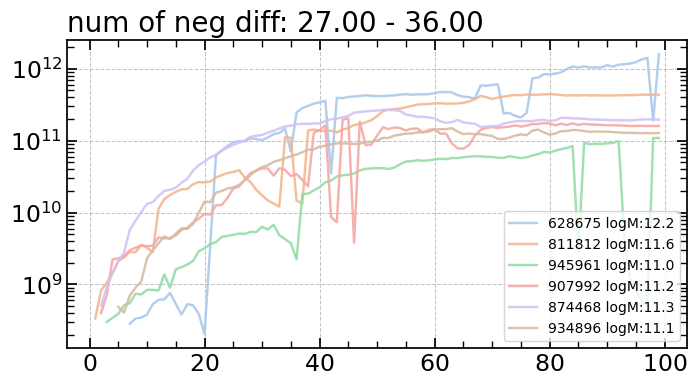

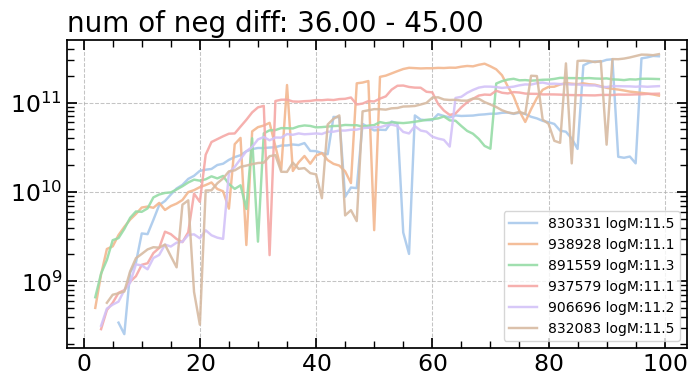

In [188]:
#bin in histories_df['mass_diff_neg_count'], 5 bins, and plot random 10 halos from each bin

cls, bins = pd.cut(histories_df['mass_diff_neg_count'], 5, labels=False, retbins=True)

n_sample = 6
for i in range(5):
    fig,  ax =  plt.subplots( figsize = (8,4))
    group = histories_df[cls==i]
    for j, row in enumerate(group.sample(n_sample).index) if len(group)>n_sample else enumerate(group.index):
        snap = histories_df.loc[row]['snap']
        mass = histories_df.loc[row]['mass']
        logmass = histories_df.loc[row]['log_subhalomass']
        ax.plot(snap, mass, alpha=0.9, label=str(row)+f' logM:{logmass:.1f}')

    gr_label = f'num of neg diff: {bins[i]:.2f} - {bins[i+1]:.2f}'
    ax.set_title(gr_label)
    ax.legend(fontsize = 10)
    ax.set_yscale('log')

## Explore images

In [189]:
subhalos_df

SubhaloCM  SubhaloGrNr  SubhaloHalfmassRad  \
subhaloID                                                                       
0           [825.4651, 26360.812, 18043.373]            0          650.651184   
24681       [19805.244, 47818.293, 48904.41]            1          736.517456   
44062      [23815.764, 33120.215, 41404.504]            2          402.670837   
59551       [10984.191, 50821.13, 47625.277]            3          541.652344   
74363      [68437.766, 59068.484, 54036.723]            4          465.475220   
...                                      ...          ...                 ...   
958184      [19628.703, 73197.56, 32715.139]        18249           23.170107   
958375      [4825.373, 24298.955, 16737.156]        18280           24.481579   
958424      [23199.18, 12566.774, 15933.126]        18291           20.256176   
958504       [67693.02, 58742.934, 57075.24]        18305           23.407728   
958525     [61758.855, 44600.797, 553.66364]        18310           23.419779   

                         SubhaloHalfmassRadType  SubhaloIDMostbound  \
subhaloID                                                             
0           [0.0, 650.6512, 0.0, 0.0, 0.0, 0.0]          5797961333   
24681      [0.0, 736.51746, 0.0, 0.0, 0.0, 0.0]          2325180566   
44062      [0.0, 402.67084, 0.0, 0.0, 0.0, 0.0]          1987826536   
59551      [0.0, 541.65234, 0.0, 0.0, 0.0, 0.0]           864268477   
74363      [0.0, 465.47522, 0.0, 0.0, 0.0, 0.0]          4983576378   
...                                         ...                 ...   
958184     [0.0, 23.170107, 0.0, 0.0, 0.0, 0.0]          1326341395   
958375     [0.0, 24.481579, 0.0, 0.0, 0.0, 0.0]           755109533   
958424     [0.0, 20.256176, 0.0, 0.0, 0.0, 0.0]          2504767413   
958504     [0.0, 23.407728, 0.0, 0.0, 0.0, 0.0]          4972318880   
958525     [0.0, 23.419779, 0.0, 0.0, 0.0, 0.0]          4898597161   

           SubhaloLen             SubhaloLenType   SubhaloMass  \
subhaloID                                                        
0            47955681  [0, 47955681, 0, 0, 0, 0]  28771.916016   
24681        45435206  [0, 45435206, 0, 0, 0, 0]  27259.708984   
44062        23858229  [0, 23858229, 0, 0, 0, 0]  14314.195312   
59551        38959666  [0, 38959666, 0, 0, 0, 0]  23374.587891   
74363        23558059  [0, 23558059, 0, 0, 0, 0]  14134.102539   
...               ...                        ...           ...   
958184          11817     [0, 11817, 0, 0, 0, 0]      7.089832   
958375          11755     [0, 11755, 0, 0, 0, 0]      7.052634   
958424          11768     [0, 11768, 0, 0, 0, 0]      7.060434   
958504          11738     [0, 11738, 0, 0, 0, 0]      7.042435   
958525          11763     [0, 11763, 0, 0, 0, 0]      7.057434   

           SubhaloMassInHalfRad        SubhaloMassInHalfRadType  ...  \
subhaloID                                                        ...   
0                           0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
24681                       0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
44062                       0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
59551                       0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
74363                       0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
...                         ...                             ...  ...   
958184                      0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
958375                      0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
958424                      0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
958504                      0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   
958525                      0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  ...   

                                SubhaloMassType SubhaloParent  \
subhaloID                                                       
0          [0.0, 28771.916, 0.0, 0.0, 0.0, 0.0]             0   
24681      [0.0, 27259.709, 0.0, 0.0, 0.0, 0.0]             0   
4

Using precomputed histogram: 74363


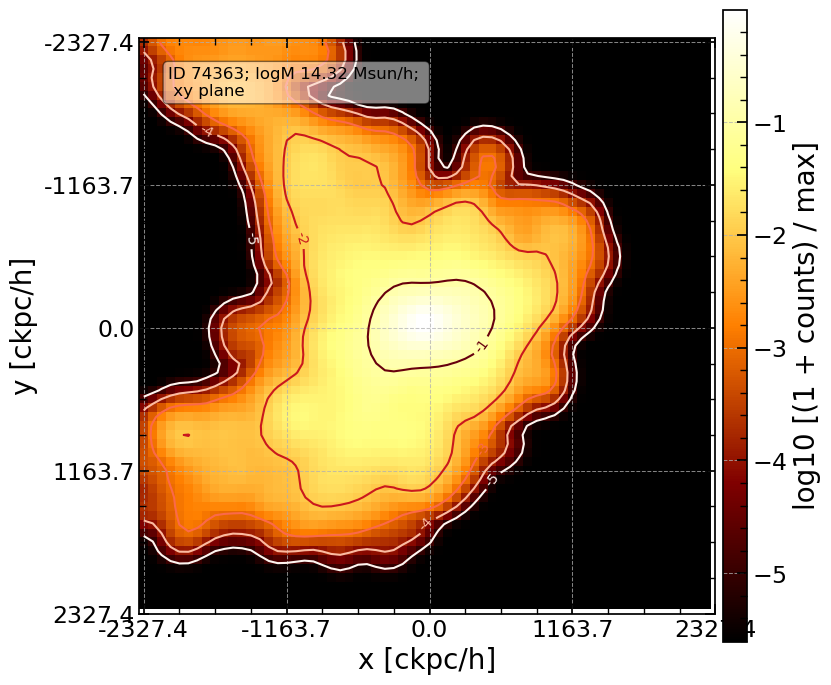

In [190]:
halo = HaloInfo(74363)
#halo.plot_all(None, cmap = 'jet');
halo.plot_2d_density(None, cmap = 'afmhot')

Using precomputed histogram: 74363


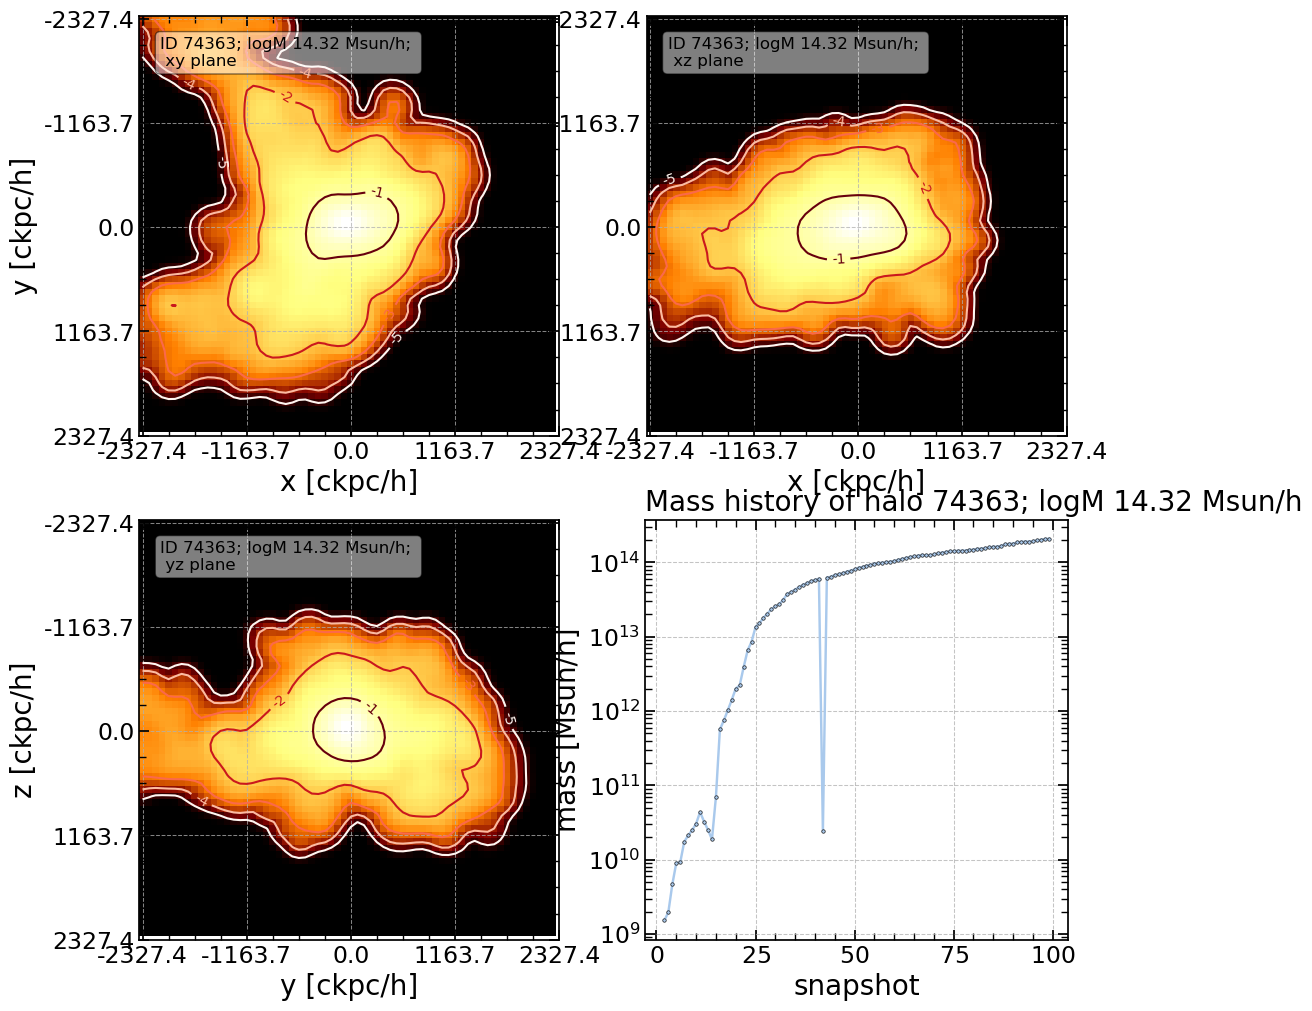

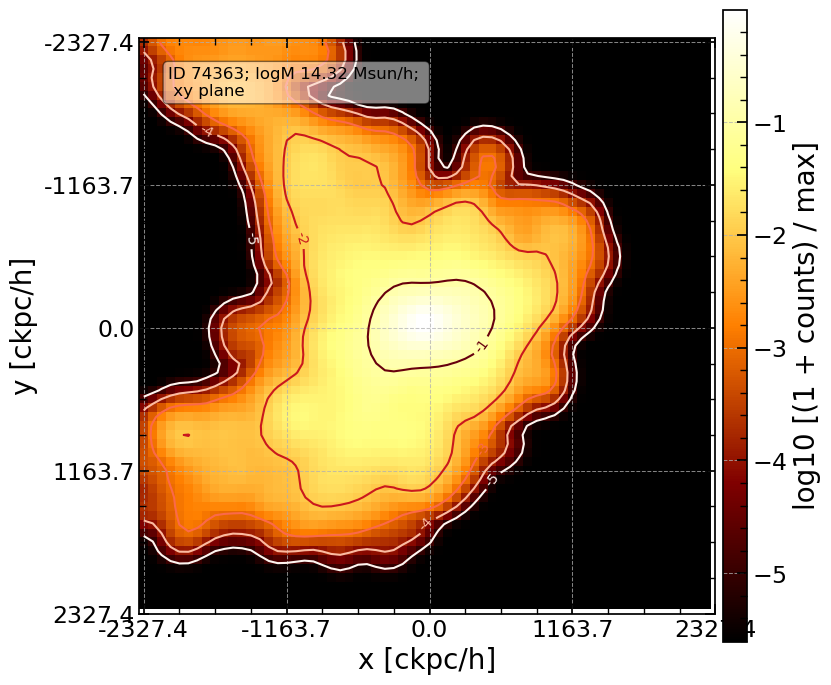

In [191]:
halo = HaloInfo(74363)
halo.plot_all(None);


Using precomputed histogram: 943977
Using precomputed histogram: 936649
Using precomputed histogram: 898341
Using precomputed histogram: 889890
Using precomputed histogram: 879807
Using precomputed histogram: 869108
Using precomputed histogram: 819069
Using precomputed histogram: 753638
Using precomputed histogram: 811934
Using precomputed histogram: 793907
Using precomputed histogram: 765751
Using precomputed histogram: 759928
Using precomputed histogram: 746030
Using precomputed histogram: 712086
Using precomputed histogram: 702932
Using precomputed histogram: 682708
Using precomputed histogram: 640659
Using precomputed histogram: 644949
Using precomputed histogram: 635842
Using precomputed histogram: 615049
Using precomputed histogram: 586542
Using precomputed histogram: 577988
Using precomputed histogram: 543105
Using precomputed histogram: 537788
Using precomputed histogram: 498639
Using precomputed histogram: 500581
Using precomputed histogram: 463379
Using precomputed histogram:

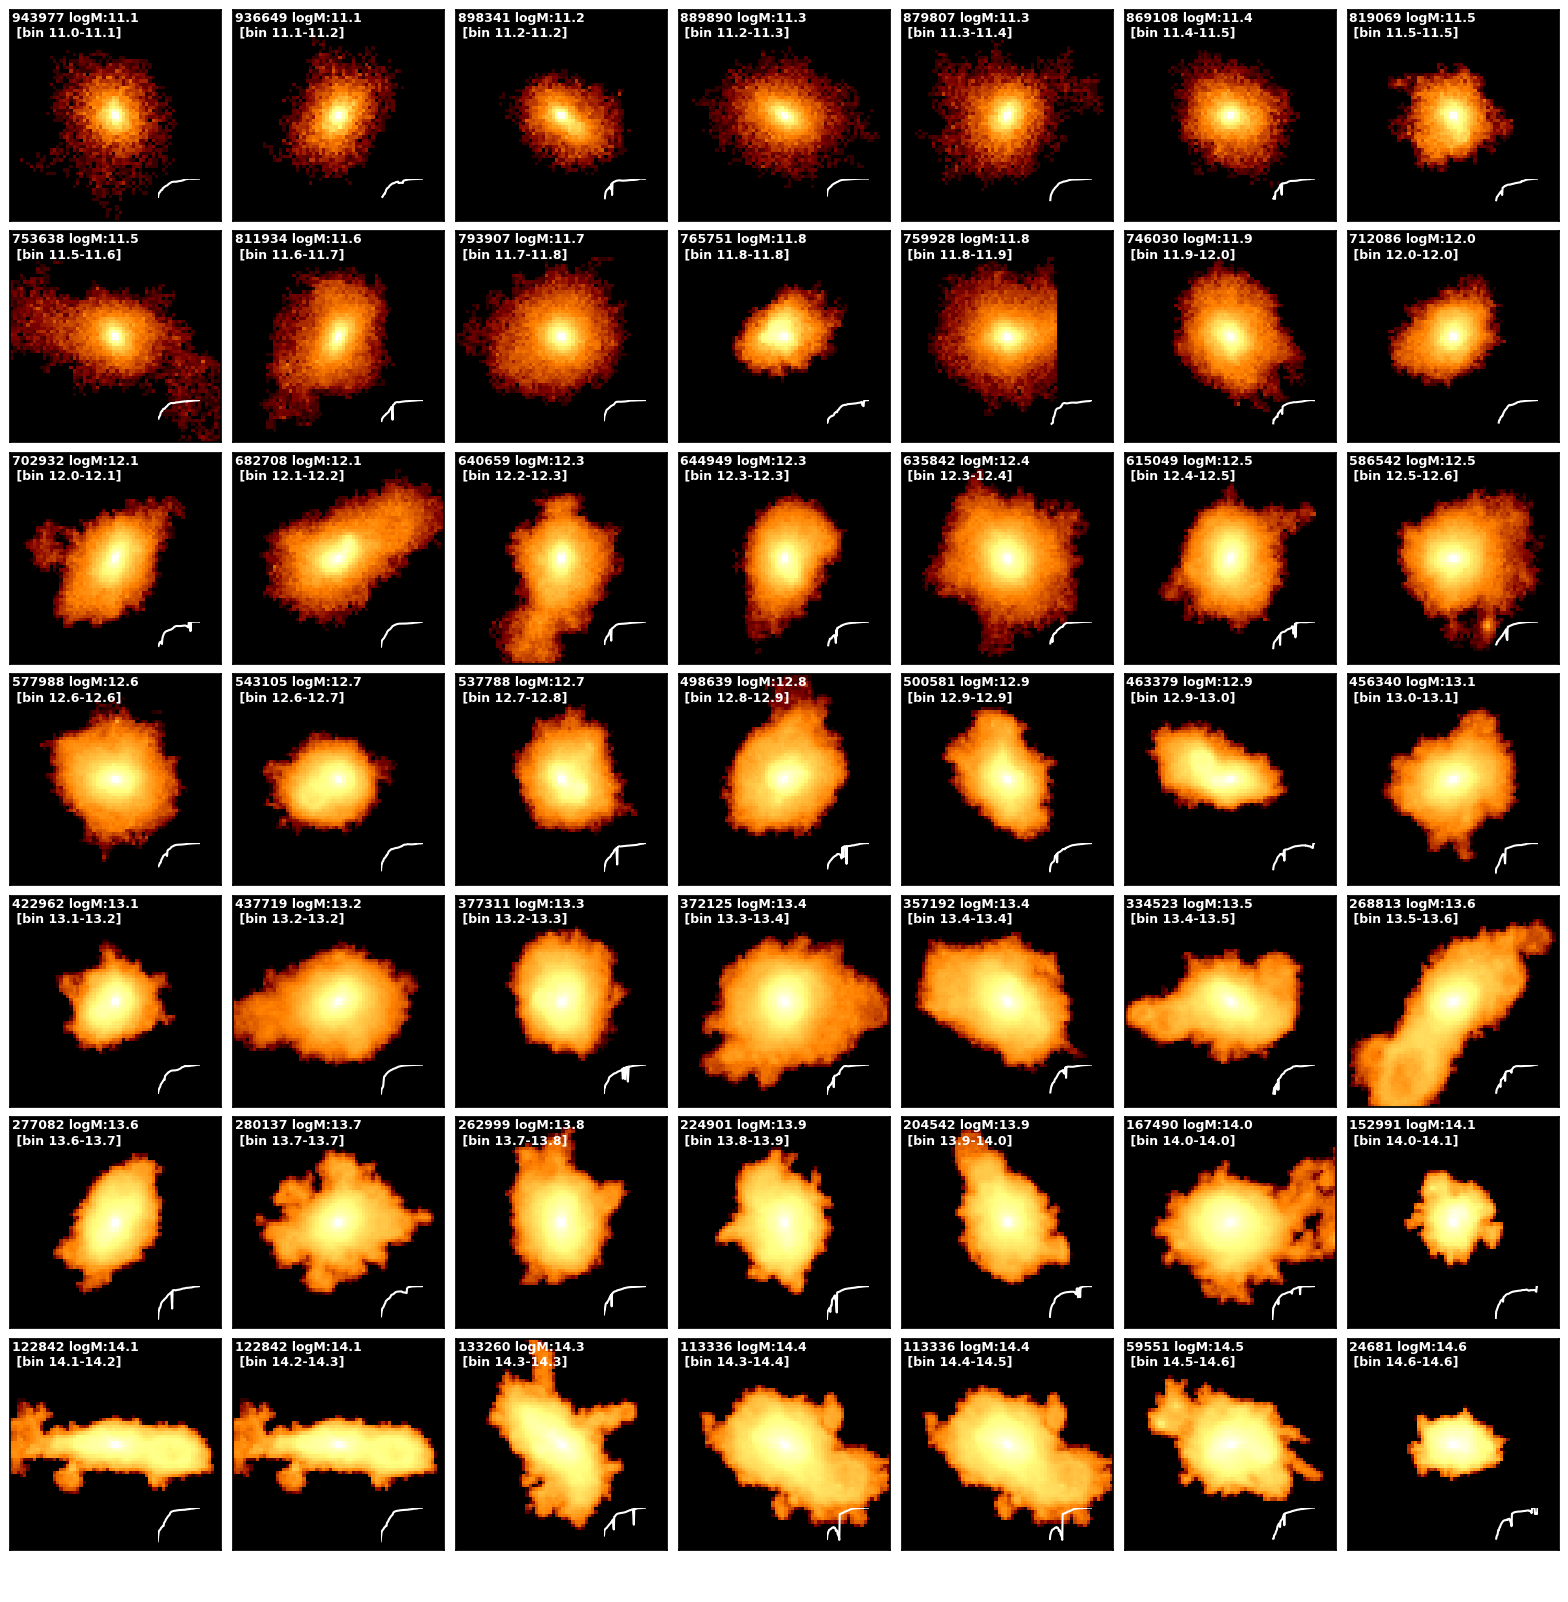

In [322]:
n_rows = 7
n_cols = n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

mass_cls, bins = pd.cut(subhalos_df['logSubhaloMass'], n_rows*n_cols, labels=False, retbins=True)

for i in range(n_rows):
    for j in range(n_cols):
        mass = bins[i*n_cols+j]
        mass_hi = bins[i*n_cols+j+1] if i*n_cols+j+1<len(bins) else 16

        subdf = subhalos_df.query(f'logSubhaloMass>{mass} & logSubhaloMass<{mass_hi}')
        if len(subdf)==0:
            haloid = haloid
        else:
            haloid = subdf.sample(1).index[0]
        
        halo = HaloInfo(haloid)

        halo.make_3d_density()
        orig_arr = halo.dens['projections']['xz']
        arr = 1+orig_arr
        arr = arr / np.max(arr)
        arr = np.log10(arr)


        mass_hist = histories_df.loc[halo.haloid]
        arr_mass = np.log10(mass_hist['mass'])/np.max(np.log10(mass_hist['mass']))
        arr_snap = mass_hist['snap']/99

        axes[i, j].imshow(arr, cmap='afmhot')

        #plot mass history as inset (transparent background white lines)
        inset = axes[i, j].inset_axes([0.7, -0.2, 0.2, 0.4], transform=axes[i, j].transAxes)
        inset.plot(arr_snap, arr_mass, color='white', lw=1.5)
        inset.set_xlim(0, 1)
        inset.set_ylim(0, 1)
        inset.axis('off')
        #make white border
        #inset.spines['bottom'].set_color('white')
        #inset.spines['top'].set_color('white')
        #inset.spines['right'].set_color('white')
        #inset.spines['left'].set_color('white')




        bin_left = bins[i*n_cols+j]
        bin_right = bins[i*n_cols+j+1] if i*n_cols+j+1<len(bins) else 16
        #axes[i, j].set_title(f'{bin_left:.1f}<M<{bin_right:.1f}')
        lbl = f'{halo.haloid} logM:{halo.mass_log_msun:.1f} \n [bin {bin_left:.1f}-{bin_right:.1f}]'
        axes[i, j].text(0, 0, lbl, color='white', fontsize=9, fontweight='bold', ha='left', va='top')


        #remove ticks and labels
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

#set space between subplots
#plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()




Using precomputed histogram: 930610
Using precomputed histogram: 764529
Using precomputed histogram: 633899
Using precomputed histogram: 557046
Using precomputed histogram: 400369
Using precomputed histogram: 218717
Using precomputed histogram: 113336


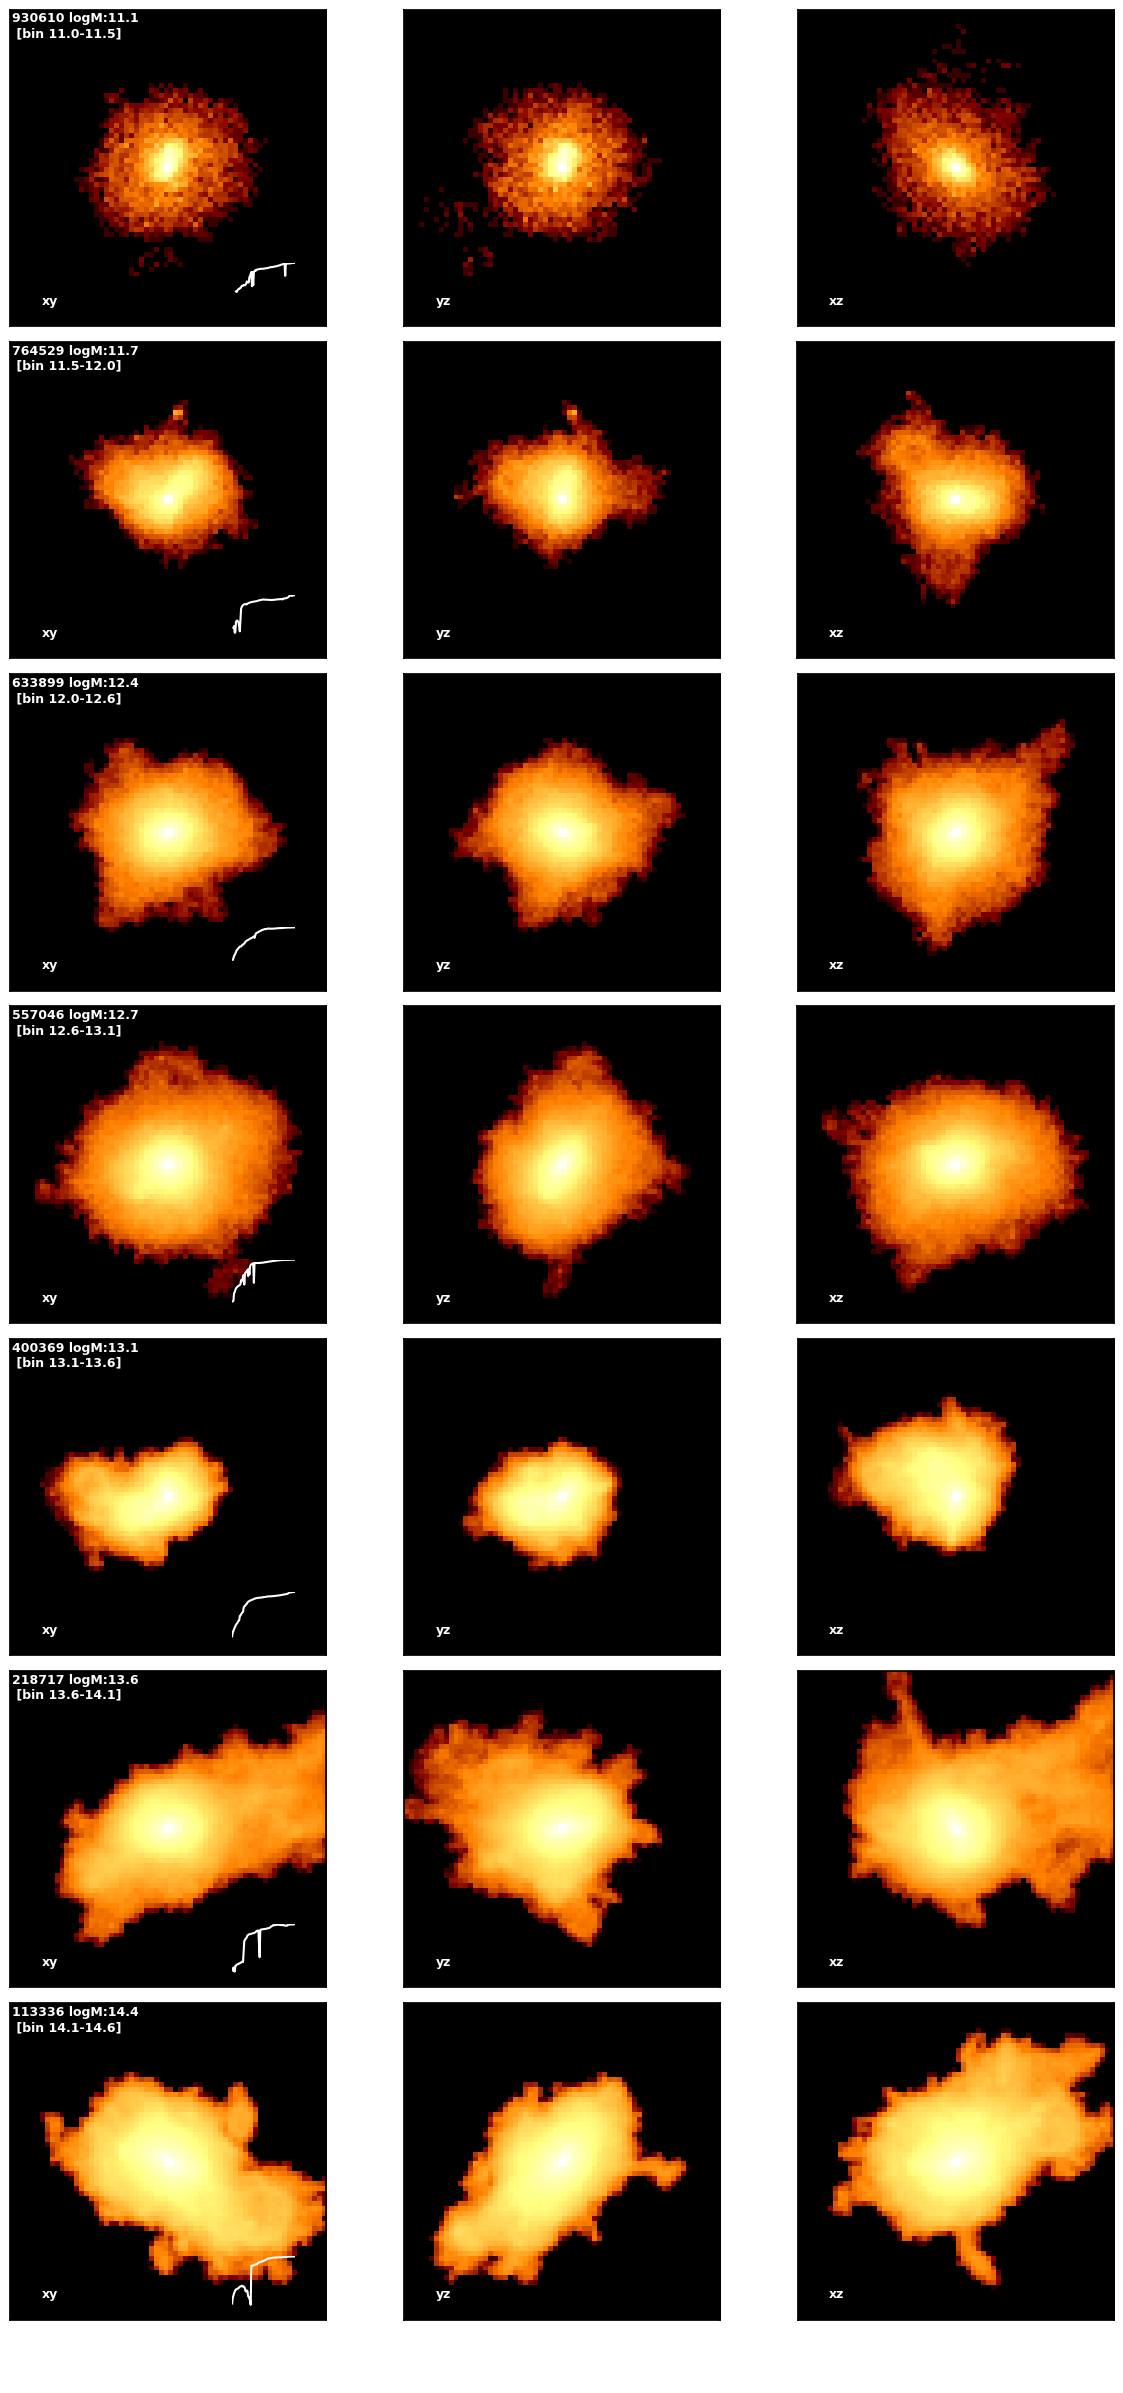

In [339]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize= (15, 30))

mass_cls, bins = pd.cut(subhalos_df['logSubhaloMass'], n_rows, labels=False, retbins=True)

for i in range(n_rows):
    mass = bins[i]
    mass_hi = bins[i+1] if i+1<len(bins) else 16

    subdf = subhalos_df.query(f'logSubhaloMass>{mass} & logSubhaloMass<{mass_hi}')
    if len(subdf)==0:
        haloid = haloid
    else:
        haloid = subdf.sample(1).index[0]

    halo = HaloInfo(haloid)
    halo.make_3d_density()
    arr_xz = halo.dens['projections']['xz']
    arr_yz = halo.dens['projections']['yz']
    arr_xy = halo.dens['projections']['xy']

    arr_xz = np.log10((1+arr_xz)/np.max(arr_xz+1))
    arr_yz = np.log10((1+arr_yz)/np.max(arr_yz+1))
    arr_xy = np.log10((1+arr_xy)/np.max(arr_xy+1))


    mass_hist = histories_df.loc[halo.haloid]
    arr_mass = np.log10(mass_hist['mass'])/np.max(np.log10(mass_hist['mass']))
    arr_snap = mass_hist['snap']/99

    axes[i, 0].imshow(arr_xz, cmap='afmhot')
    axes[i, 1].imshow(arr_yz, cmap='afmhot')
    axes[i, 2].imshow(arr_xy, cmap='afmhot')

    #plot mass history as inset (transparent background white lines)
    inset = axes[i, 0].inset_axes([0.7, -0.2, 0.2, 0.4], transform=axes[i, 0].transAxes)
    inset.plot(arr_snap, arr_mass, color='white', lw=1.5)
    inset.set_xlim(0, 1)
    inset.set_ylim(0, 1)
    inset.axis('off')
    #make white border
    #inset.spines['bottom'].set_color('white')
    #inset.spines['top'].set_color('white')
    #inset.spines['right'].set_color('white')
    #inset.spines['left'].set_color('white')




    #axes[i, j].set_title(f'{bin_left:.1f}<M<{bin_right:.1f}')
    lbl = f'{halo.haloid} logM:{halo.mass_log_msun:.1f} \n [bin {mass:.1f}-{mass_hi:.1f}]'
    axes[i, 0].text(0, 0, lbl, color='white', fontsize=9, fontweight='bold', ha='left', va='top')

    axes[i, 0].text(0.1, 0.1, 'xy', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 0].transAxes)
    axes[i, 1].text(0.1, 0.1, 'yz', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 1].transAxes)
    axes[i, 2].text(0.1, 0.1, 'xz', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 2].transAxes)

    #remove ticks and labels
    for j in range(3):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

#set space between subplots
#plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()


Using precomputed histogram: 0


(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: xlabel='x [ckpc/h]', ylabel='y [ckpc/h]'>,
         <Axes: xlabel='x [ckpc/h]', ylabel='z [ckpc/h]'>],
        [<Axes: xlabel='y [ckpc/h]', ylabel='z [ckpc/h]'>,
         <Axes: title={'left': 'Mass history of halo 0; logM 14.63 Msun/h'}, xlabel='snapshot', ylabel='mass [Msun/h]'>]],
       dtype=object))

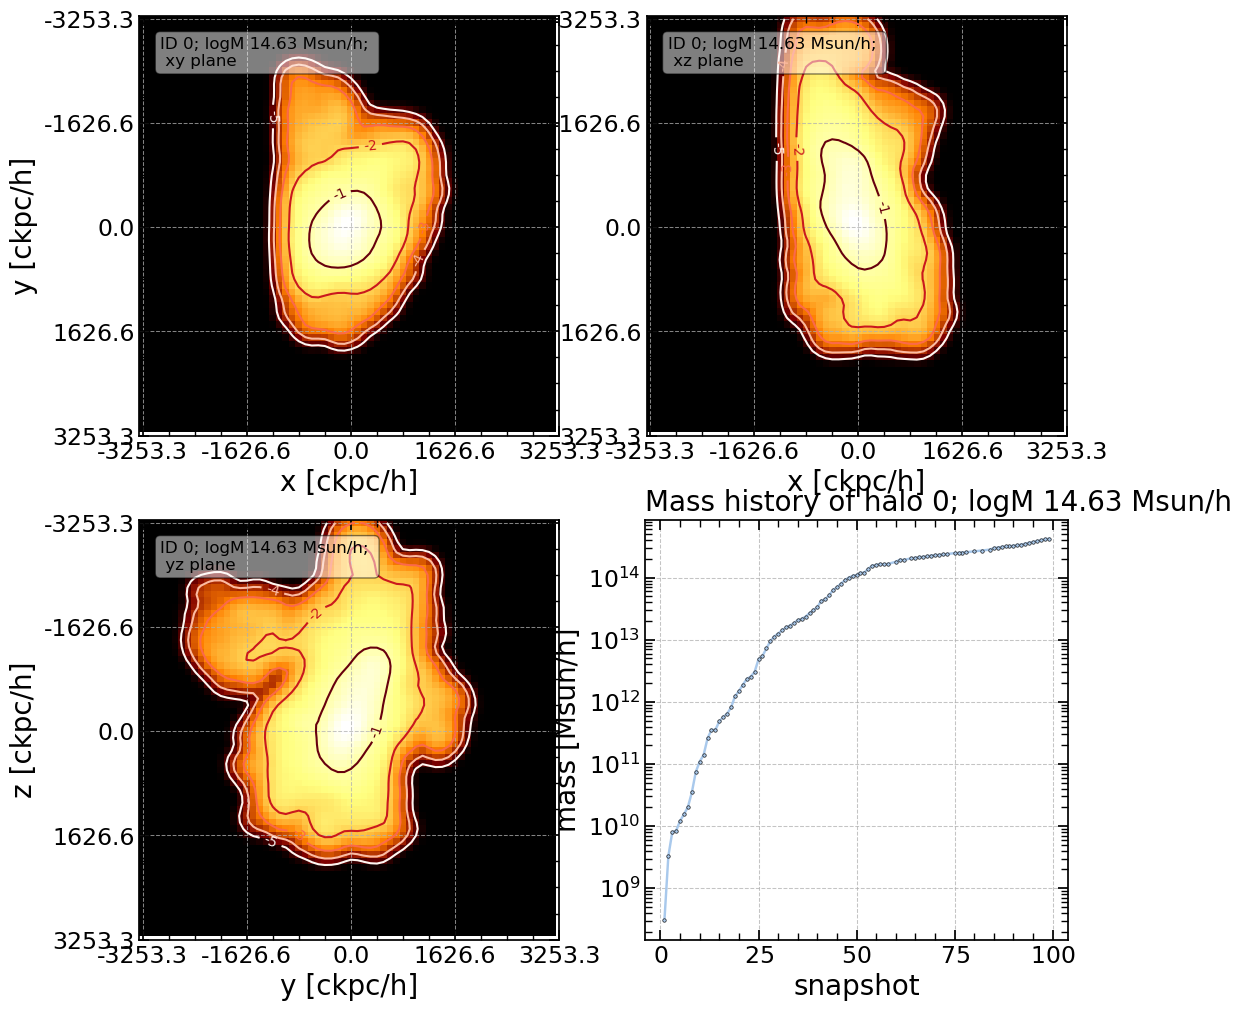

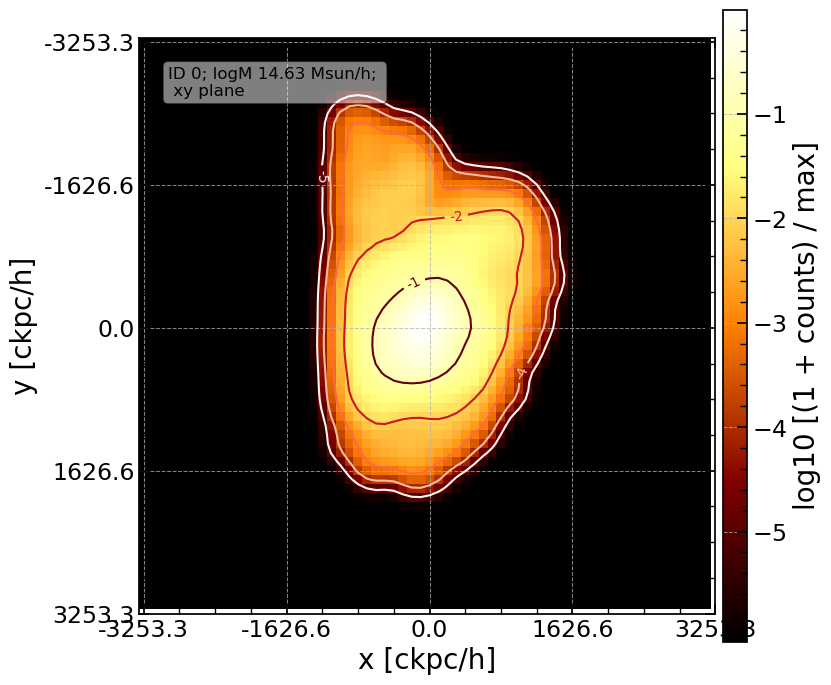

In [233]:
HaloInfo(0).plot_all(None)

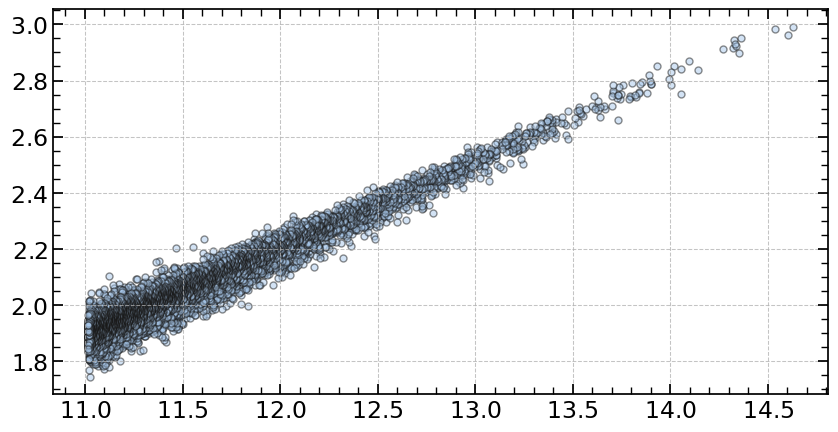

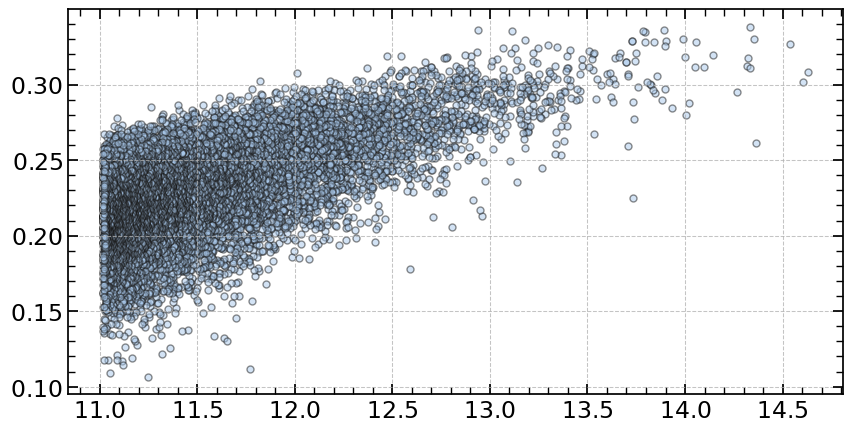

In [313]:
vd = np.log10(subhalos_df['SubhaloVmax'] )
m = subhalos_df['logSubhaloMass']

spins = subhalos_df['SubhaloSpin'].to_numpy()
#spins shape is a list of 3d vectors, make it 2d array
spins = np.array([x for x in spins])
spin_mag = np.linalg.norm(spins, axis=1)

spin_mag = np.log10(spin_mag)

plt.figure(figsize=(10, 5))
plt.scatter(m, vd, alpha=0.5)


plt.figure(figsize=(10, 5))
plt.scatter(m, spin_mag/m, alpha=0.5)

# prepare data for ML

In [466]:
#raise ValueError('stop here')
postprocess_path = data_path[:-4]+'/freya_postprocess/'
save_3d = False

for id in tqdm(subhalos_df.index): #3 min for saving without 3d data
    halo = HaloInfo(id)
    halo.make_3d_density()
    data_transform = halo.data_transform(dens = None, smooth=None)

    map_2d_xz = data_transform['map_2d_xz']
    map_2d_yz = data_transform['map_2d_yz']
    map_2d_xy = data_transform['map_2d_xy']

    snap = data_transform['snapshot']
    mass_hist = data_transform['mass_hist']

    if save_3d:
        map_3d = data_transform['map_3d']
    else:
        map_3d = np.zeros(1)
    
    
    fname_root = f'{postprocess_path}halo_{id}'

    np.savez(fname_root, 
                map_3d = map_3d,
                map_2d_xz = map_2d_xz,
                map_2d_yz = map_2d_yz,
                map_2d_xy = map_2d_xy,
                snap = snap,
                mass = mass_hist)



100%|██████████| 16544/16544 [03:05<00:00, 89.02it/s] 


In [479]:
subhalos_df['logSubhaloMass'].describe()

count    16544.000000
mean        11.489002
std          0.465126
min         11.016729
25%         11.153178
50%         11.345632
75%         11.678537
max         14.628123
Name: logSubhaloMass, dtype: float64

array([11.  , 11.37, 11.74, 12.11, 12.48, 12.85, 13.22, 13.59, 13.96,
       14.33, 14.7 ])

In [495]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


#mass bins for classification
bins = np.linspace(11, 14.7, 11)

class HaloDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, load_3d = False):
        self.root_dir = root_dir
        
        self.files = glob(root_dir+'*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]

        self.load_3d = load_3d

    def __len__(self):
        return len(self.halos_ids)
    
    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        fname_root = f'{self.root_dir}halo_{halo_id}'

        data = np.load(fname_root+'.npz')
        data_xy = data['map_2d_xy']
        data_xz = data['map_2d_xz']
        data_yz = data['map_2d_yz']
        snap = data['snap']
        snap_mass = data['mass']
        data_3d = data['map_3d'] 

        label_mass = subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, bins)
        label = (label_mass, label_class)

        del data

        
        tuple_to_resuts = data_3d,(data_xy, data_xz, data_yz), (snap, snap_mass)

        return tuple_to_resuts, label
    

dataset = HaloDataset(postprocess_path, load_3d = False)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True) #TODO upweight high mass halos, otherwise they will probably be severely underrepresented

for i_batch, sample_batched in enumerate(dataloader):
    break



-----

# Old Stuff: USING DOWNLOADED SNAPSHOTS

In [ ]:
# from photutils.isophote import Ellipse
# from photutils.isophote import EllipseGeometry
# from photutils.isophote import build_ellipse_model
# geometry = EllipseGeometry(x0=30, y0=30, sma=20, eps=0.5,
#                            pa=20.0 * np.pi / 180.0)
# ellipse = Ellipse(arr, geometry)
# isolist = ellipse.fit_image()

# model_image = build_ellipse_model(arr.shape, isolist)
# residual = arr - model_image
# plt.imshow(model_image, cmap='viridis')

In [193]:
raise Exception('stop here')

Exception: stop here

In [ ]:
#downloaded_halos = os.listdir(data_path+'/')
downloaded_halos = glob(data_path+'/*_cutout.hdf5')
downloaded_halos = [halo.split('_')[1] for halo in downloaded_halos]
downloaded_halos = list([int(i) for i in downloaded_halos])
downloaded_halos.sort()

In [ ]:
from utils.data.tng_query import HaloInfo

halo_lowmass = HaloInfo(958424)
halo_highmass = HaloInfo(59551)

for halo in [halo_lowmass, halo_highmass]:
    dens = halo.make_3d_density()
    halo.plot_all(dens)

In [ ]:
from utils.data.tng_query import HaloInfo

halo = HaloInfo(958424)
dens = halo.make_3d_density()

hist_file = np.load(data_path[:-4]+'freya/halo_958424_hist.npz')

assert np.all(hist_file['hist'] == dens['hist']), 'error in data'